# Convolution Operation

type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
size of image: (150, 150)


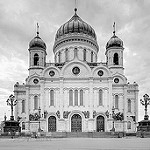

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("./figs/building.jpg")
# PIL 객체 확인
print("type: {}".format(type(img)))
# 이미지 흑백으로 변경, 크기변화: 150x150x3 > 150x150x1
img = img.convert("L") 
# 이미지 크기 조회
print("size of image: {}".format(img.size))
img

In [2]:
import torch
import numpy as np
# img_tensor: height, weight
img_tensor = torch.Tensor(np.array(img))

[[ -5.  -2.  24.]
 [-15.  -9.  17.]
 [-15. -20.  -4.]]


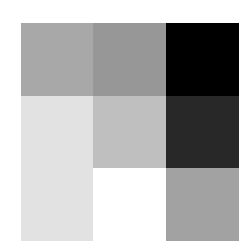

In [3]:
# 이미지
ex_img = np.array([[13,  1,  1,  3,  4], 
                   [12, 14, 14,  2,  2],
                   [ 1,  0, 16, 12,  1],
                   [ 3,  3,  1, 12, 11],
                   [ 2,  2,  4,  1, 13]])
ex_img_tensor = torch.Tensor(ex_img)

# 커널
kernel = torch.Tensor([[1, 0, -1], 
                       [1, 0, -1], 
                       [1, 0, -1]])

# 합성곱 연산 함수 정의
def convolution_opteration(x, kernel):
    """convolution operation"""
    # for 문을 돌리기 위한 크기 산출
    *_, height, weight = x.size()
    kernel_size = kernel.size(0)
    # 합성곱 연산 진행
    convs = []
    for i in range(height-kernel_size+1):
        c = [torch.sum(x[i:(i+kernel_size), j:(j+kernel_size)] * kernel) for j in range(weight-kernel_size+1)]
        convs.append(c)
    convs = torch.Tensor(convs)
    return convs

# 합성곱 연산
convs = convolution_opteration(ex_img_tensor, kernel)
print(np.array(convs))

# 합성곱 연산 후,이미지
fig, ax = plt.subplots(1, 1)
ax.matshow(np.array(convs), cmap="binary")
ax.axis("off")
plt.show()

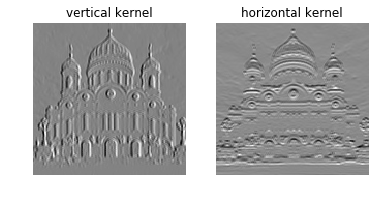

In [4]:
# vertical kernel(filter)
vertical_kernel = torch.Tensor([[1, 0, -1], 
                                [1, 0, -1], 
                                [1, 0, -1]])
vertical_convs = convolution_opteration(img_tensor, vertical_kernel)

# horizontal kernel(filter)
horizontal_kernel = torch.Tensor([[ 1,  1,  1], 
                                  [ 0,  0,  0], 
                                  [-1, -1, -1]])
horizontal_convs = convolution_opteration(img_tensor, horizontal_kernel)

# 그림
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(vertical_convs.numpy(), cmap="binary")
ax1.axis("off")
ax1.set_title("vertical kernel")
ax2.imshow(horizontal_convs.numpy(), cmap="binary")
ax2.axis("off")
ax2.set_title("horizontal kernel")
plt.show()

Size After Convolution Operation: torch.Size([1, 1, 148, 148])


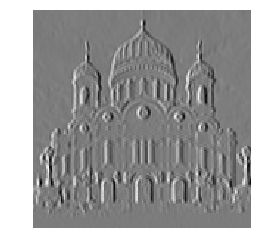

In [5]:
import torch
import torch.nn as nn

# img_tensor: batch, channel, height, weight
img_tensor = torch.Tensor(np.array(img)).expand(1, 1, 150, 150)

# Input Size: batch, in_channel, height, weight 
batch, in_channels, height, weight = img_tensor.size()
out_channels = 1
kernel_size = 3
stride = 1

# 직접 만든 함수와 똑같이 만들기 위해서 bias=False, kernel weight 를 조정한다.
conv_layer = nn.Conv2d(in_channels=in_channels, 
                       out_channels=out_channels, 
                       kernel_size=kernel_size, 
                       stride=stride,
                       bias=False)
conv_layer.weight.data = vertical_kernel.expand(1, 1, kernel_size, kernel_size)
convs = conv_layer(img_tensor)

# 합성곱 연산 후 크기 및 이미지 확인
print("Size After Convolution Operation: {}".format(convs.size()))
plt.imshow(convs.squeeze().detach().numpy(), cmap="gray")
plt.axis("off")
plt.show()

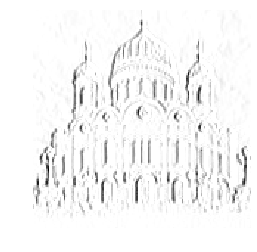

In [6]:
# 활성화 맵
activation_maps = torch.relu(convs)

# 활성화 맵 그림
plt.imshow(activation_maps.squeeze().detach().numpy(), cmap="binary")
plt.axis("off")
plt.show()

---

# Pooling

In [13]:
def pooling(x, kernel_size, stride=None):
    """max pooling"""
    assert x.ndimension() == 4, "only support 4d tensor"
    if stride is None:
        stride = kernel_size
    b, c, height, weight = x.size()
    maxpool = x.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride).max(-1)[0].max(-1)[0]
    return maxpool

# 최대 풀링
maxpools = pooling(activation_maps, kernel_size=2)

Size After MaxPooling Operation: torch.Size([1, 1, 74, 74])


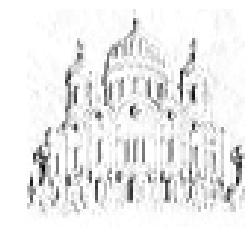

In [14]:
# 최대 풀링 층 정의 및 연산
maxpool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
maxpools = maxpool_layer(activation_maps)

# 최대 풀링 연산 후 크기 및 이미지 확인
print("Size After MaxPooling Operation: {}".format(maxpools.size()))
plt.imshow(maxpools.squeeze().detach().numpy(), cmap="binary")
plt.axis("off")
plt.show()

---

# Multiple kernels & Padding & Stride

$$\begin{aligned} h_{out} &= \dfrac{h_{in} + 2p - k}{s} + 1 \\ 
 w_{out} &= \dfrac{w_{in} + 2p - k}{s} + 1 \end{aligned}$$

Convolution operation result size: torch.Size([1, 5, 74, 74])


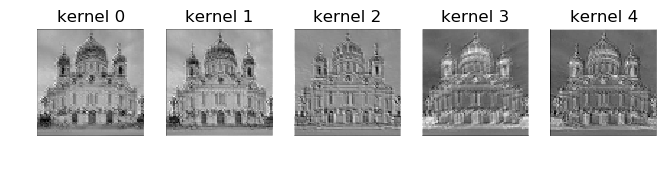

In [15]:
torch.manual_seed(70)

batch, in_channels, height, weight = img_tensor.size()
out_channels = 5
kernel_size = 6
padding = 1
stride = 2

# Input Size: batch, c_in, n_in, n_in  (1, 1, 150, 150) 
# Output Size: batch, c_out, n_out, n_out (1, 5, 74, 74)
# (150 + 2*1 - 6)/2 + 1 = 74
conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
convs = conv_layer(img_tensor)
print("Convolution operation result size: {}".format(convs.size()))

# 각 필터가 무엇을 하는지 시각화
fig, axes = plt.subplots(1, 5, figsize=(8, 12), dpi=100)
for i in range(convs.size(1)):
    axes[i].imshow(convs.squeeze()[i, :, :].detach().numpy(), cmap="binary")
    axes[i].set_title("kernel {}".format(i))
    axes[i].axis("off")
plt.show()

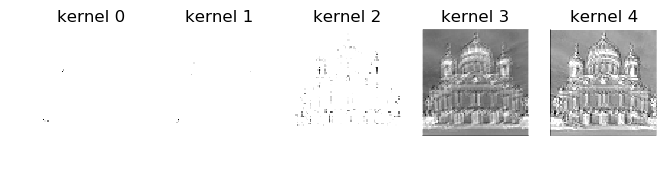

In [16]:
activation_layer = nn.ReLU()
activation_maps = activation_layer(convs)

# 활성화 맵 시각화
fig, axes = plt.subplots(1, 5, figsize=(8, 12), dpi=100)
for i in range(convs.size(1)):
    axes[i].imshow(activation_maps.squeeze()[i, :, :].detach().numpy(), cmap="binary")
    axes[i].set_title("kernel {}".format(i))
    axes[i].axis("off")
plt.show()

MaxPool operation result size: torch.Size([1, 5, 37, 37])


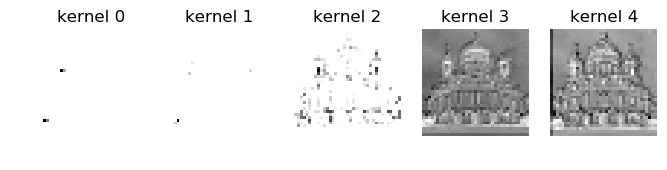

In [17]:
maxpool_kernel_size = 2

# Input Size: batch, c_in, n_in, n_in (1, 5, 74, 74) 
# Output Size: batch, c_out, n_out, n_out (1, 5, 37, 37)
# (150 + 2*0 - 2)/2 + 1 = 74

maxpool_layer = nn.MaxPool2d(kernel_size=maxpool_kernel_size)
maxpools = maxpool_layer(activation_maps)
print("MaxPool operation result size: {}".format(maxpools.size()))

# 활성화 맵 시각화
fig, axes = plt.subplots(1, 5, figsize=(8, 12), dpi=100)
for i in range(maxpools.size(1)):
    axes[i].imshow(maxpools.squeeze()[i, :, :].detach().numpy(), cmap="binary")
    axes[i].set_title("kernel {}".format(i))
    axes[i].axis("off")
plt.show()